<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Линейная-регресися" data-toc-modified-id="Линейная-регресися-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Линейная регресися</a></span></li><li><span><a href="#Дерево-решений" data-toc-modified-id="Дерево-решений-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Дерево решений</a></span></li><li><span><a href="#Случайный-лес" data-toc-modified-id="Случайный-лес-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Случайный лес</a></span></li><li><span><a href="#CatBoostRegressor" data-toc-modified-id="CatBoostRegressor-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>CatBoostRegressor</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

# 1 Подготовка

импорт библиотек

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import Lasso, Ridge



Загружаем датасет, предварительно сделам столбец с датами и временем индексовым

In [2]:
df = pd.read_csv('/datasets/taxi.csv',  parse_dates=[0], index_col=0)

Посмотрим на данные

In [3]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [4]:
df.tail()

,num_orders
datetime,
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27
2018-08-31 23:40:00,39
2018-08-31 23:50:00,53


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Предварительно можно сказать, что данные хранятся в диапазоне 2018-03-01 - 2018-08-31, это можно проверить. Для этого отсортируем индексы и посмотрим на крайние значения, также посмотрим сохраняется ли непрерывный хронологический порядок - посмотрим на монотонность

In [6]:
df = df.sort_index()

In [7]:
df.index.unique()

DatetimeIndex(['2018-03-01 00:00:00', '2018-03-01 00:10:00',
               '2018-03-01 00:20:00', '2018-03-01 00:30:00',
               '2018-03-01 00:40:00', '2018-03-01 00:50:00',
               '2018-03-01 01:00:00', '2018-03-01 01:10:00',
               '2018-03-01 01:20:00', '2018-03-01 01:30:00',
               ...
               '2018-08-31 22:20:00', '2018-08-31 22:30:00',
               '2018-08-31 22:40:00', '2018-08-31 22:50:00',
               '2018-08-31 23:00:00', '2018-08-31 23:10:00',
               '2018-08-31 23:20:00', '2018-08-31 23:30:00',
               '2018-08-31 23:40:00', '2018-08-31 23:50:00'],
              dtype='datetime64[ns]', name='datetime', length=26496, freq=None)

In [8]:
df.index.is_monotonic

True

<AxesSubplot:xlabel='datetime'>

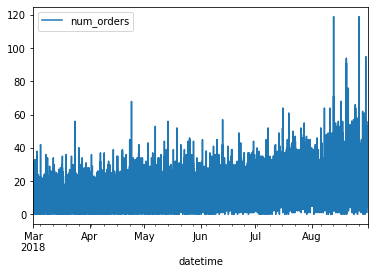

In [9]:
df.plot()

Все верно, теперь тк нас интересует кол-во действий на след час, группируем выборку по 1 часу

In [10]:
df = df.resample('1H').sum()

<AxesSubplot:xlabel='datetime'>

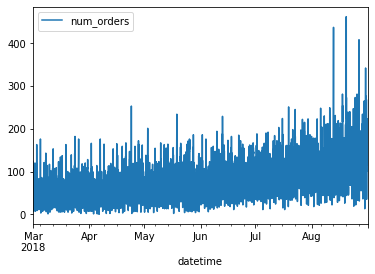

In [11]:
df.plot()

In [12]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [13]:
df.tail()

,num_orders
datetime,
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159
2018-08-31 22:00:00,223
2018-08-31 23:00:00,205


**Итог**

В данных не было обнаружено ошибок(пропусков, не верного типа данных). Применил ресемплирование по 1 часу и обозначил почему

# Анализ

Изучим данные для выявления закономерностей, таких как тренд или сезон

Отельно посмотрю, как показывают себя данные в разбивке по месяцам

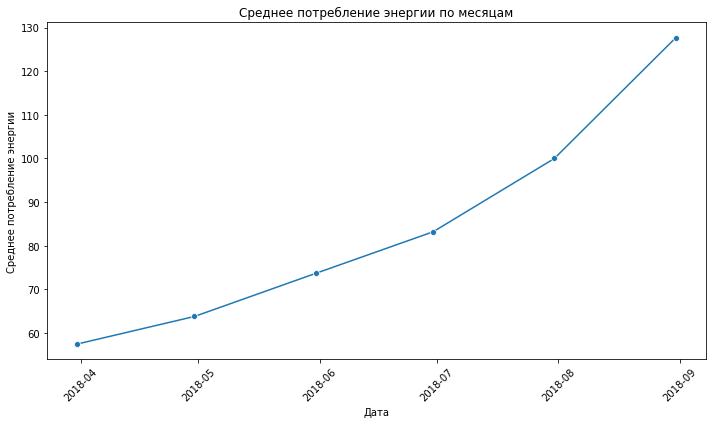

In [14]:
monthly_df = df.resample('1M').mean()

# Оформление графика с помощью библиотеки Seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(data=monthly_df, x=monthly_df.index, y='num_orders', marker='o')

plt.title('Среднее потребление энергии по месяцам')
plt.xlabel('Дата')
plt.ylabel('Среднее потребление энергии')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

Виден непрерывный рост, похоже на тренд, точно сказать сезонность или нет нельзя, тк у нас данные только за 1 не полный год

In [15]:
decomposed = seasonal_decompose(df) 

Text(0.5, 1.0, 'Seasonality')

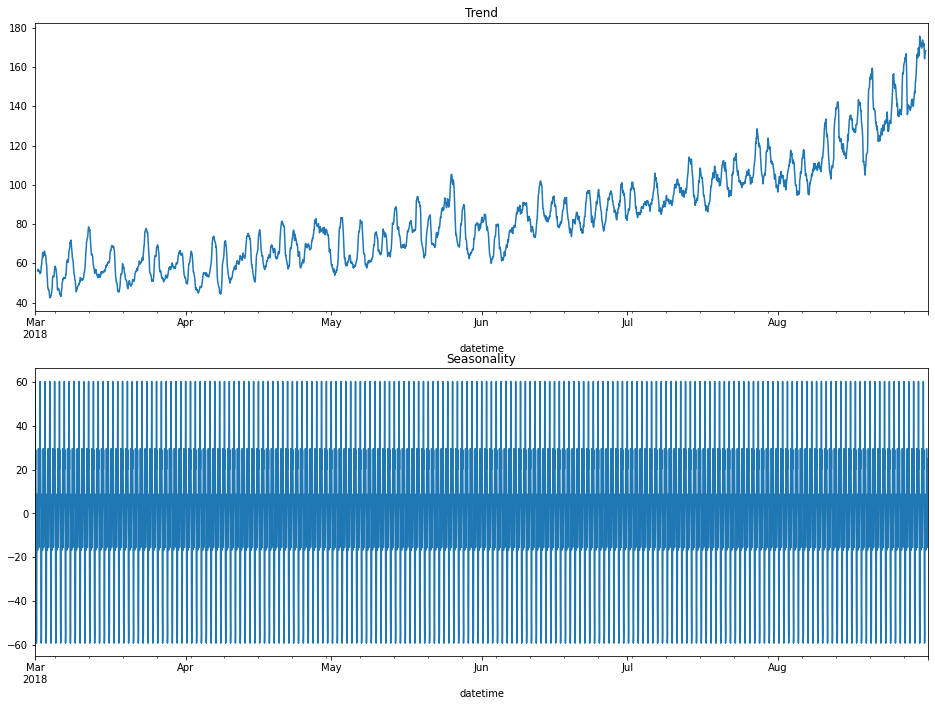

In [16]:
plt.figure(figsize=(16, 18))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')


С первым графиком все ясно, действительно похоже на тренд, с каждым годом обычно все больше людей находятся в аэропортах, многим нужно такси

Со втрым не ясно, нужно рассмотреть ближе

<AxesSubplot:xlabel='datetime'>

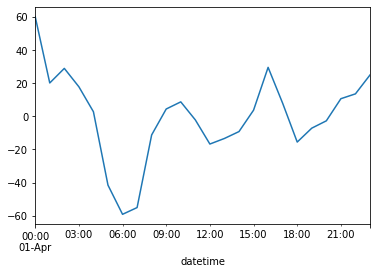

In [17]:
decomposed.seasonal['2018-04-01': '2018-04-1'].plot()

Видно, что каждый день появляются большие колебания. Самый пик в 00, 3, 10 и 16-17 часов, спрос в 6 часов самый маленький

# Обучение

Перед обучением создадим признаки необходимые для обучения

In [18]:
def make_features(data, max_lag, rolling_mean_size):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()


In [19]:
make_features(df,24,24)

Сделал так, потому что у нас есть повторы горячих точке каждые 24 часа,а нам надо предсказать на день, разбив по дням данные, значит значение должно быть 24

создание выборок для обучения

In [20]:
train, test = train_test_split(df, shuffle=False, test_size=0.1)
train = train.dropna()

разделение признаков от целевого признака

In [21]:

train_f = train.drop('num_orders', axis=1)
train_t = train['num_orders']

test_f = test.drop('num_orders', axis=1)
test_t = test['num_orders']



Создаем линейную регрессию и обучаем ее кроссом

## Линейная регресися

In [22]:
model = LinearRegression()
model.fit(train_f, train_t)
predictions = model.predict(train_f)

In [23]:
rmse = mean_squared_error(train_t, predictions, squared=False)
rmse

25.818602103995378

Хороший результат, идем дальше. Обучаем дерево

## Дерево решений

In [24]:
model = DecisionTreeRegressor(random_state=12345)

In [25]:
parameters = {'max_depth':range(1,20,1)}

tscv = TimeSeriesSplit(n_splits=2)

In [26]:

gsearch = GridSearchCV(estimator=model, cv=tscv, param_grid=parameters)

In [27]:

train_f = train.drop('num_orders', axis=1)
train_t = train['num_orders']

test_f = test.drop('num_orders', axis=1)
test_t = test['num_orders']



In [28]:
gsearch.fit(train_f, train_t)
gsearch.best_params_

{'max_depth': 3}

In [29]:
predictions = gsearch.predict(train_f)
rmse = mean_squared_error(train_t, predictions, squared=False)
rmse

27.824415377953354

Результат похуже, теперь лес

## Случайный лес

In [30]:

model = RandomForestRegressor(random_state=12345)

In [31]:
parameters = {'n_estimators':range(10,100,10), 'max_depth':range(1,5,1)}

tscv = TimeSeriesSplit(n_splits=2)

In [32]:
gsearch = GridSearchCV(estimator=model, cv=tscv, param_grid=parameters)

In [33]:
gsearch.fit(train_f, train_t)
gsearch.best_params_

{'max_depth': 4, 'n_estimators': 70}

In [34]:
predictions = gsearch.predict(train_f)
rmse = mean_squared_error(train_t, predictions, squared=False)
rmse

25.294965542358742

Результат близкий к результату дерева, но чуть лучше


## CatBoostRegressor

In [35]:
from catboost import CatBoostRegressor

In [36]:
model = CatBoostRegressor(verbose=False)
model.fit(train_f, train_t)
predictions = model.predict(train_f)
rmse = mean_squared_error(train_t, predictions, squared=False)
rmse

11.178335981311683

Отличный результат. Входе работы я удалил метод LightGBM в связи с тем, что он очень долго обучался, при этом выдавав результат не такой хороший как catboost

# Тестированиие

Изобразим на графике реальные данные из трейна и предсказанные

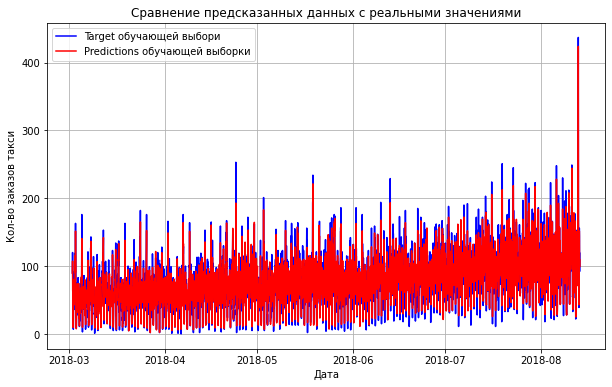

In [37]:



time_labels_real = train_t.index 

plt.figure(figsize=(10, 6))
plt.plot(time_labels_real, train_t, label='Target обучающей выбори', color='blue')
plt.plot(time_labels_real, predictions[:len(train_t)], label='Predictions обучающей выборки', color='red')

plt.xlabel('Дата')
plt.ylabel('Кол-во заказов такси')
plt.title('Сравнение предсказанных данных с реальными значениями')
plt.legend()
plt.grid(True)


plt.show()


Отличный результат, можно проверить его на тестовой выборке

In [38]:
predictions = model.predict(test_f)
rmse = mean_squared_error(test_t, predictions, squared=False)
rmse

40.46969263531542

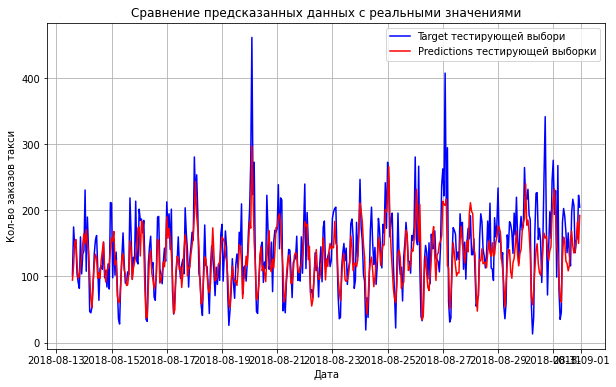

In [39]:



time_labels_real = test_t.index 

plt.figure(figsize=(10, 6))
plt.plot(time_labels_real, test_t, label='Target тестирующей выбори', color='blue')
plt.plot(time_labels_real, predictions[:len(test_t)], label='Predictions тестирующей выборки', color='red')

plt.xlabel('Дата')
plt.ylabel('Кол-во заказов такси')
plt.title('Сравнение предсказанных данных с реальными значениями')
plt.legend()
plt.grid(True)


plt.show()


Результат хуже, чем на обучающей выборке, однако соответствует желанию заказчика, можно оставять


**Итоговый вывод**

Для того, что бы найти модель, которая справится с прогнозом я обучил несколько моделей с помощью подбора гиперпараметров и кросс валидацией. 

- Линейная регрессия показала неплохой результат на оучающей выборке, однако все другие модели справились намного лучше
- Деревянные модели показали неплохой результат, с быстрой скоростью обучения
- Градиентный бустинг показал самый лучший показатель метрики при этом потратив очень мало времени на обчения

Самым оптимальным решением я счиатаю использовать CatBoostRegressor, метрика самая низкая, скорость обучения также 
очень быстрая